In [10]:
import os
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers, optimizers
from MultiLabel_File import utils
data_path = "datasets/CNN_ACC_SEV_V1.v2i.multiclass"

print("TensorFlow version:", tf.__version__)
print("GPU Build Info:", tf.sysconfig.get_build_info())
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Bellek optimizasyonu (GPU kullanımı için)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)#TensorFlow’un başlangıçta minimum bellek tahsis etmesini ve yalnızca gerektiğinde bellek kullanmasını sağlar.

TensorFlow version: 2.10.1
GPU Build Info: OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def load_data(subset):
    """
    Dataseti içeri aktarır.
    :param subset: (test,train,valid)
    :return: csv dataset
    """
    csv_path = os.path.join(data_path, subset , "_classes.csv")
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip() #sütun adlarındaki boşlukları temizle.

    #filename sütununu path'e çevirme
    df['filename'] = df['filename'].apply(lambda x: os.path.normpath(os.path.join(data_path, subset, x)))
    return df

In [3]:
def create_dataset(df):
    images =df["filename"].values
    labels = df[["moderate-accident","no-accident","severe-accident"]].values.astype("float32")#tf ile uyumlu olması için float32 tipine dönüştürülür.

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))#tf dataset

    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)# ön işleme için lambda fonk ve performans opt(paralel işleme)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)#performans opt.
    return dataset

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)#imageleri byte formatında okur, henüz çözümleme yapılmadı
    img = tf.image.decode_jpeg(img, channels=3)#resmi 3 kanallı tensöre çevrildi
    img = tf.image.resize(img, [224, 224])#standart boyutlaştırma
    img = img / 255.0# model learning için piksel değerlerini 0–1 aralığına çeker.
    return img


In [4]:
#Orjinal veriler
train_df = load_data("train")
valid_df = load_data("valid")
test_df = load_data("test")
print(f"{len(train_df)} train samples")
print(f"{len(valid_df)} validation samples")
print(f"{len(test_df)} test samples\n")

print(f"Ciddi Dereceli Kaza: {train_df['severe-accident'].sum()}")
print(f'Orta Dereceli Kaza: {train_df["moderate-accident"].sum()}')
print(f'Kaza Yok: {train_df["no-accident"].sum()}')

#Tensorflow Datasetler
train_df = create_dataset(train_df)
valid_df = create_dataset(valid_df)
test_df = create_dataset(test_df)
print(test_df)

7452 train samples
712 validation samples
354 test samples

Ciddi Dereceli Kaza: 2382
Orta Dereceli Kaza: 2439
Kaza Yok: 2631
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [5]:
def create_model():
    model =models.Sequential([
        # İlk Convolutional blok
        layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3), padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),#En önemli özellikler kalacak şekilde görüntüyü yarıya indirir.
        layers.Dropout(0.25),

        # İkinci Convolutional blok
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.25),

        # Üçüncü Convolutional blok
        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.25),

        #Çıktı Katmanı
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"),
    ])

    # Model derleme
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model
model = create_model()

In [6]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',#Doğrulama kaybını izle
        patience=5,#x epoch boyunca iyileşme olmazsa dur
        restore_best_weights=True# En iyi ağırlıklara geri dön
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',# Doğrulama kaybı durursa
        factor=0.5,# Öğrenme oranını %x azalt
        patience=3,# x epoch boyunca iyileşme olmazsa lr düşür
        min_lr=1e-6 # En düşük learningrate oranı
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "ACC_SEV_File/best_CNN_model.h5",
        monitor='val_loss',
        save_best_only=True,#en düşük val_loss olduğunda kaydet.
        mode='min',
    )
]

In [7]:
history = model.fit(
    train_df,
    validation_data=valid_df,
    epochs=30,
    callbacks=my_callbacks,
    verbose=1,
)

Epoch 1/30
233/233 [==============================] - 34s 127ms/step - loss: 1.3721 - accuracy: 0.3894 - val_loss: 1.2553 - val_accuracy: 0.3146 - lr: 0.0010
Epoch 2/30
233/233 [==============================] - 27s 118ms/step - loss: 1.1484 - accuracy: 0.4399 - val_loss: 1.0965 - val_accuracy: 0.3947 - lr: 0.0010
Epoch 3/30
233/233 [==============================] - 28s 120ms/step - loss: 1.0086 - accuracy: 0.4750 - val_loss: 1.3839 - val_accuracy: 0.3820 - lr: 0.0010
Epoch 4/30
233/233 [==============================] - 23s 98ms/step - loss: 0.9304 - accuracy: 0.5289 - val_loss: 0.9522 - val_accuracy: 0.5154 - lr: 0.0010
Epoch 5/30
233/233 [==============================] - 23s 99ms/step - loss: 0.8720 - accuracy: 0.5521 - val_loss: 0.9592 - val_accuracy: 0.4944 - lr: 0.0010
Epoch 6/30
233/233 [==============================] - 23s 97ms/step - loss: 0.8171 - accuracy: 0.5860 - val_loss: 0.8481 - val_accuracy: 0.5112 - lr: 0.0010
Epoch 7/30
233/233 [==============================] - 2

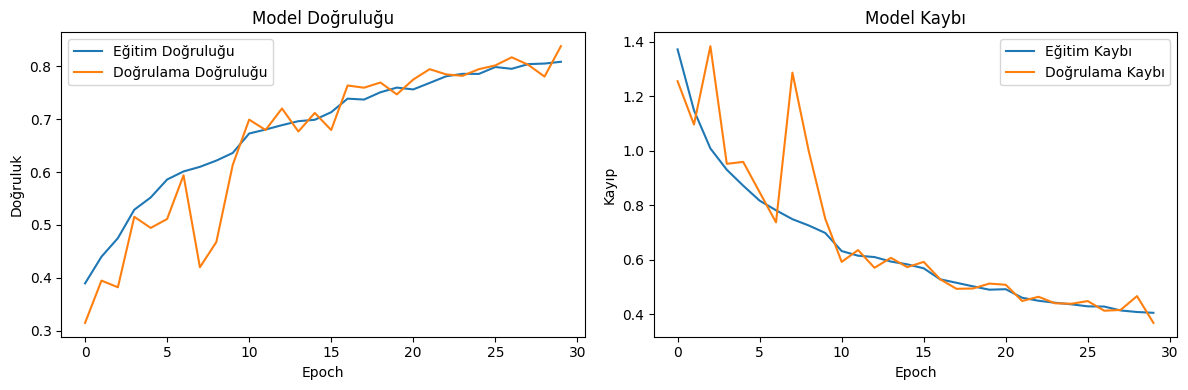

In [9]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model, test_dataset, class_names):
    """
    Eğitimli bir modelin performansını test veri seti üzerinde değerlendirir.
    Doğruluk, F1-Skor, ROC-AUC gibi metrikleri hesaplar ve karmaşıklık matrisi ile
    sınıf bazlı performans raporunu gösterir.

    Args:
        model (tf.keras.Model): Değerlendirilecek eğitilmiş model.
        test_dataset (tf.data.Dataset): Modelin test edileceği veri seti.
        class_names (list): Sınıf etiketlerinin adlarını içeren liste.
    """
    y_true = []
    y_pred = []
    y_proba = []

    for images, labels in test_dataset:
        probs = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)
        trues = np.argmax(labels.numpy(), axis=1)

        y_true.extend(trues)
        y_pred.extend(preds)
        y_proba.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    # Skorlar
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(tf.one_hot(y_true, len(class_names)), y_proba, multi_class='ovr')

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Her sınıf için detaylı metrikler
    print("\nSınıf Bazlı Performans:")
    print(classification_report(y_true, y_pred, target_names=class_names))

Accuracy: 0.8136
F1 Score: 0.8012
ROC-AUC Score: 0.9533


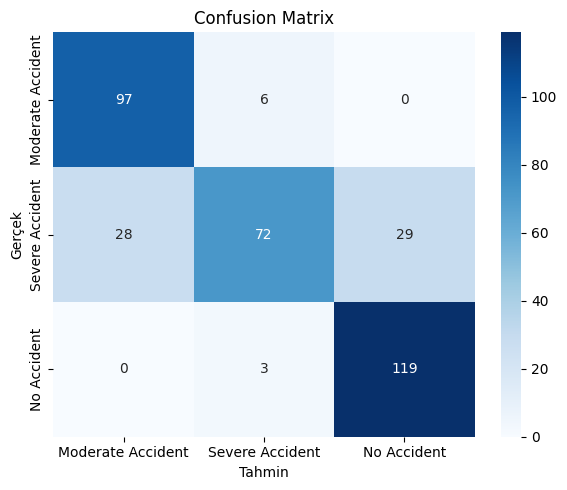


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.78      0.94      0.85       103
  Severe Accident       0.89      0.56      0.69       129
      No Accident       0.80      0.98      0.88       122

         accuracy                           0.81       354
        macro avg       0.82      0.83      0.81       354
     weighted avg       0.83      0.81      0.80       354



In [11]:
class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(model, test_df, class_names)